QuantLib vs. Our Rect Int 
   Mean Squared Error:  272.1303263184474


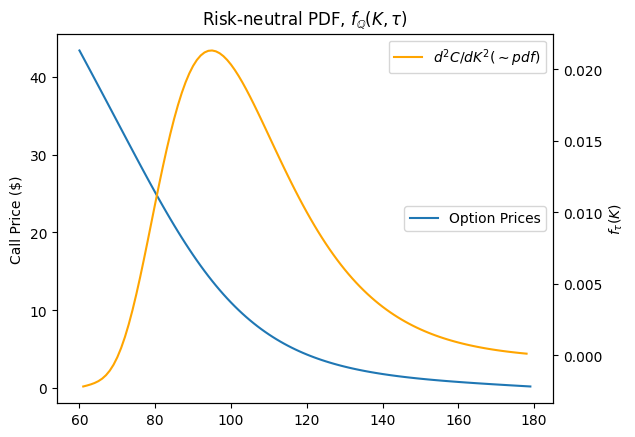

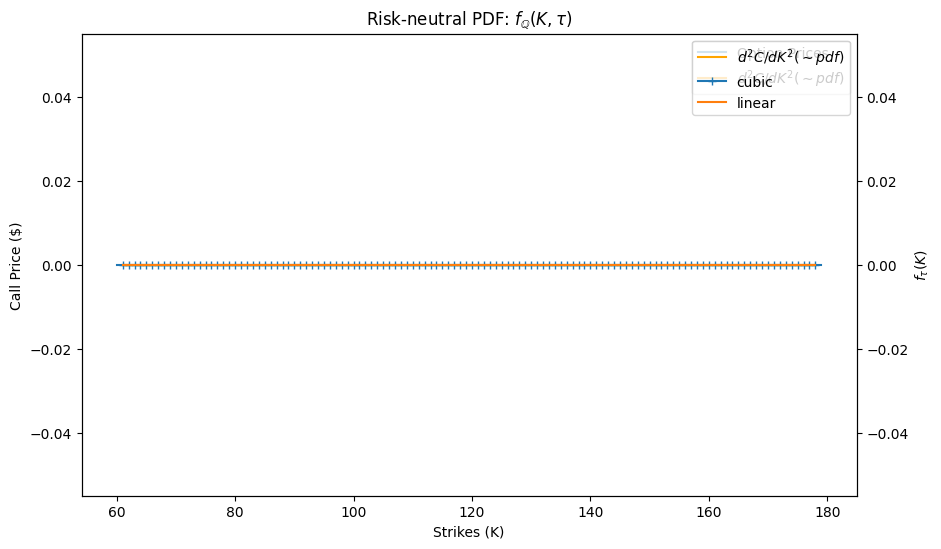

,strike,Calls,Puts
113,174.0,0.0,0.0
114,175.0,0.0,0.0
115,176.0,0.0,0.0
116,177.0,0.0,0.0
117,178.0,0.0,0.0


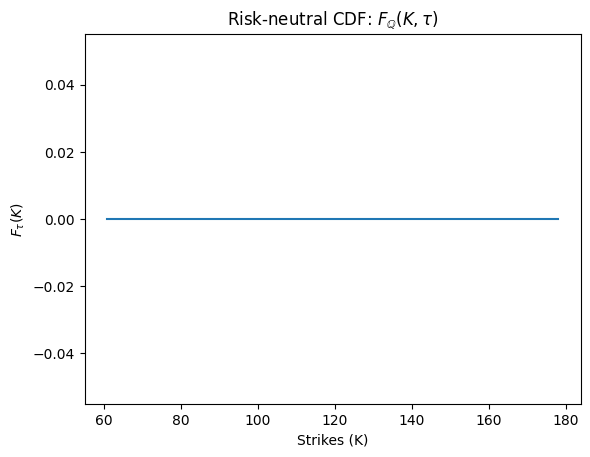

In [2]:
import numpy as np
import scipy as sc
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

S0 = 100
K = 150
tau = 1
r = 0.06

kappa = 3
theta = 0.20**2
v0 = 0.20**2
rho = 0.98
sigma = 0.2
lambd = 0

2*kappa*theta, ' > ',sigma**2

def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):

    # constants
    a = kappa*theta
    b = kappa+lambd

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rspi - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2

def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 650
    dphi=umax/N
    for j in range(1,N):
        phi = dphi * (2*j + 1)/2
        numerator = heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)

        P += dphi * numerator/denominator

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

strikes = np.arange(60, 180, 1.0)
option_prices = heston_price_rec(S0, strikes, v0, kappa, theta, sigma, rho, lambd, tau, r)

option_prices

prices = pd.DataFrame([strikes, option_prices]).transpose()
prices.columns = ['strike', 'price']
prices['curvature'] = (-2 * prices['price'] +
                       prices['price'].shift(1) +
                       prices['price'].shift(-1)) / 1**2

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ylabel('Call Price ($)')
ax2 = ax.twinx()

ax.plot(strikes, option_prices, label='Option Prices')
ax2.plot(prices['strike'], prices['curvature'], label='$d^2C/dK^2 (\sim pdf)$', color='orange')

ax.legend(loc="center right")
ax2.legend(loc="upper right")
plt.xlabel('Strikes (K)')
plt.ylabel('$f_\\tau(K)$')
plt.title('Risk-neutral PDF, $f_\mathbb{Q}(K, \\tau)$')

import QuantLib as ql
today = ql.Date(28, 5, 2022)
expiry_date = today + ql.Period(int(365*tau), ql.Days)

# Setting up discount curve
risk_free_curve = ql.FlatForward(today, r, ql.Actual365Fixed())
flat_curve = ql.FlatForward(today, 0.0, ql.Actual365Fixed())
riskfree_ts = ql.YieldTermStructureHandle(risk_free_curve)
dividend_ts = ql.YieldTermStructureHandle(flat_curve)

# Setting up a Heston model
heston_process = ql.HestonProcess(riskfree_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(S0)), v0, kappa, theta, sigma, rho)
heston_model = ql.HestonModel(heston_process)
heston_handle = ql.HestonModelHandle(heston_model)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

# Now doing some pricing and curvature calculations
vols = [heston_vol_surface.blackVol(tau, x) for x in strikes]

option_prices1 = []
for strike in strikes:
    option = ql.EuropeanOption( ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(expiry_date))

    heston_engine = ql.AnalyticHestonEngine(heston_model)
    option.setPricingEngine(heston_engine)

    option_prices1.append(option.NPV())

prices = pd.DataFrame([strikes, option_prices, option_prices1]).transpose()
prices.columns = ['strike', 'Rectangular Int','QuantLib']
prices['curvature'] = (-2 * prices['QuantLib'] + prices['QuantLib'].shift(1) + prices['QuantLib'].shift(-1)) / 1**2

# And plotting...
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.ylabel('Call Price ($)')
plt.xlabel('Strikes (K)')
ax2 = ax.twinx()
lns1 = ax.plot(strikes, option_prices1, label='Option Prices')
lns2 = ax2.plot(prices['strike'], prices['curvature'], label='$d^2C/dK^2 (\sim pdf)$', color='orange')
ax2.fill_between(prices['strike'], prices['curvature'], color='yellow', alpha=0.2)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

plt.ylabel('$f_\\tau(K)$')
plt.title('QuantLib: Risk-neutral PDF, $f_\mathbb{Q}(K, \\tau)$')

mse = np.mean( (option_prices - option_prices1)**2 )
print("QuantLib vs. Our Rect Int \n   Mean Squared Error: ", mse)
prices.dropna()
prices.head(40)

inter = prices.dropna()

pdf = sc.interpolate.interp1d(inter.strike, np.exp(r*tau)*inter.curvature, kind = 'linear')
pdfc = sc.interpolate.interp1d(inter.strike, np.exp(r*tau)*inter.curvature, kind = 'cubic')

strikes = np.arange(61, 179, 1.0)

plt.plot(strikes, pdfc(strikes), '-+', label='cubic')
plt.plot(strikes, pdf(strikes), label='linear')
plt.fill_between(strikes, pdf(strikes), color='yellow', alpha=0.2)
plt.xlabel('Strikes (K)')
plt.ylabel('$f_\\tau(K)$')
plt.title('Risk-neutral PDF: $f_\mathbb{Q}(K, \\tau)$')
plt.legend()
plt.show()

cdf = sc.interpolate.interp1d(inter.strike, np.cumsum(pdf(strikes)), kind = 'linear')

plt.plot(strikes, cdf(strikes))

plt.xlabel('Strikes (K)')
plt.ylabel('$F_\\tau(K)$')
plt.title('Risk-neutral CDF: $F_\mathbb{Q}(K, \\tau)$')

def integrand_call(x, K):
        return (x-K)*pdf(x)

def integrand_put(x, K):
        return (K-x)*pdf(x)

calls, puts = [], []
for K in strikes:
    call_int, err = sc.integrate.quad(integrand_call, K, 178, limit=1000, args=K)

    put_int, err = sc.integrate.quad(integrand_put, 61, K, limit=1000, args=K)

    call = np.exp(-r*tau)*call_int
    calls.append( call )

    put = np.exp(-r*tau)*put_int
    puts.append( put )

rnd_prices = pd.DataFrame([strikes, calls, puts]).transpose()
rnd_prices.columns = ['strike', 'Calls','Puts']
rnd_prices.tail()